# Pylops - Non-stationary convolution

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` operators to perform non-stationary convolution with on-the-fly interpolation between the available filters (which are provided at a coarser grid then the grid of computation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

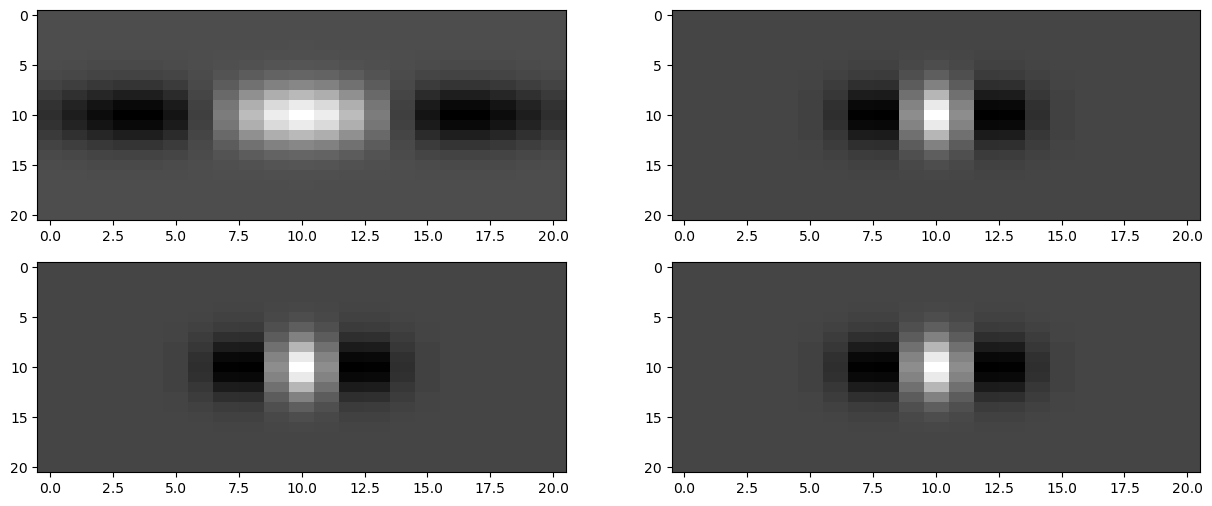

In [2]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

nx, nz = 601, 501

wav1a, _, wav1c = ricker(t[:11], f0=15)
wav1b = ricker(t[:11], f0=40)[0]
wav2 = sp.signal.windows.gaussian(21, 2.)

wav11 = np.outer(wav1a, wav2[np.newaxis]).T
wav12 = np.outer(wav1b, wav2[np.newaxis]).T
wav21 = np.outer(wav1b, wav2[np.newaxis]).T
wav22 = np.outer(wav1b, wav2[np.newaxis]).T
wavsize = wav11.shape

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(wav11, 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(wav12, 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(wav21, 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(wav22, 'gray')
axs[1,1].axis('tight');

In [3]:
hs = np.zeros((2, 2, *wavsize))
hs[0, 0] = wav11
hs[0, 1] = wav12
hs[1, 0] = wav21
hs[1, 1] = wav22

Copnp = NonStationaryConvolve2D(hs=hs, ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="numpy")
Cop = NonStationaryConvolve2D(hs=hs, ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="numba")
Copcp = NonStationaryConvolve2D(hs=cp.asarray(hs), ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="cuda")

dottest(Copnp, verb=True), dottest(Cop, verb=True), dottest(Copcp, verb=True, backend='cupy');

Dot test passed, v^H(Opu)=618.8197370095179 - u^H(Op^Hv)=618.8197370095145
Dot test passed, v^H(Opu)=-743.5627195103855 - u^H(Op^Hv)=-743.5627195103825
Dot test passed, v^H(Opu)=589.9439845684446 - u^H(Op^Hv)=589.9439845684467


In [4]:
# Forward
x = np.zeros((nx, nz))
x[:, 201] = 1.
x[:, 401] = -1.
xcp = cp.asarray(x)

Cop * x #dry-run
Copcp * xcp #dry-run
%timeit -n1 -r1 Copnp * x
%timeit -n1 -r1 Cop * x
%timeit -n1 -r1 Copcp * xcp

4.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
115 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.28 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
# Adjoint
Cop.H * x #dry-run
Copcp.H * xcp #dry-run
%timeit -n1 -r1 Copnp.H * x
%timeit -n1 -r1 Cop.H * x
%timeit -n1 -r1 Copcp.H * xcp

5.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.97 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
